In [69]:
import skfmm
from scipy.ndimage import distance_transform_edt
from scipy.signal import convolve2d
from main import *
import seaborn as sns

import pandas as pd

from tqdm import tqdm

In [70]:
# name = 'C1-29-08-2025 E12 R1 - E4 PBS-EdU+E6 GFP - EdU 647 - GFP+HuCD 488 - SOX2 555'
# name = 'C1-29-08-2025 E12 R1 f - E4 FGF2-EdU+E6 FGF2 - EdU 647 - GFP+HuCD 488 - SOX2 555'
# name = 'test_22'
# name = 'test_mouse'
name = 'test_both'

donut, res = get_picture2D(f'pics/{name}.tif')
ref_points, _ = get_picture2D(f'pics/{name}_points.tif')

if res[0] is None:
    res = (1,1)

donut = np.pad(donut, pad_width=5, mode='constant', constant_values=0)
ref_points = np.pad(ref_points, pad_width=5, mode='constant', constant_values=0)

donut = smoothing(donut)

smoothing factor = 5.78


c:\Users\USUARIO\anaconda3\envs\image-env\Lib\site-packages\aicsimageio\readers\tiff_reader.py:148: UserWarning: Could not parse tiff pixel size: 'unit'
  warnings.warn(f"Could not parse tiff pixel size: {e}")
c:\Users\USUARIO\anaconda3\envs\image-env\Lib\site-packages\aicsimageio\readers\tiff_reader.py:148: UserWarning: Could not parse tiff pixel size: 'unit'
  warnings.warn(f"Could not parse tiff pixel size: {e}")


In [71]:
height, width = donut.shape

donut_mask = donut != 0

# we should have only ventricle and outside regions
labeled, n = label(~ donut_mask)

if n != 2:
    raise ValueError('problem with masks, too many regions')

# outside label is the label of the pixel on the top left
outside_label = labeled[(0,0)]
outside_mask = labeled == outside_label
# ventricle is the other region
ventr_mask = (labeled != outside_label) & (~ donut_mask)

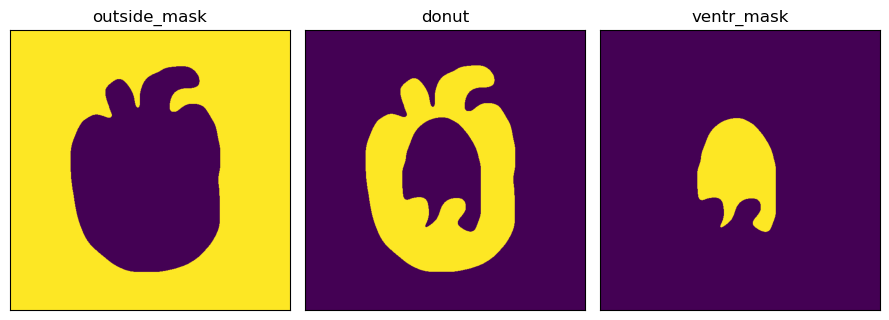

In [72]:
fig, axs = plt.subplots(1, 3, figsize = (9,4))

axs[0].set_title('outside_mask')
axs[0].imshow(outside_mask)

axs[1].set_title('donut')
axs[1].imshow(donut)

axs[2].set_title('ventr_mask')
axs[2].imshow(ventr_mask)


for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()

In [73]:
edge_in = find_edge(ventr_mask)
edge_out = find_edge(outside_mask)

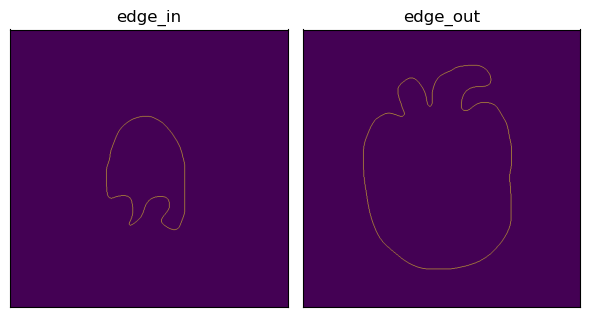

In [74]:
fig, axs = plt.subplots(1, 2, figsize = (6,4))

axs[0].set_title('edge_in')
axs[0].imshow(edge_in)

axs[1].set_title('edge_out')
axs[1].imshow(edge_out)


for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()

In [75]:
tissue = np.ma.MaskedArray(~edge_in, ~donut)
distance_from_in = skfmm.distance(tissue, dx=res)

tissue = np.ma.MaskedArray(~edge_out, ~donut)
distance_from_out = skfmm.distance(tissue, dx=res)


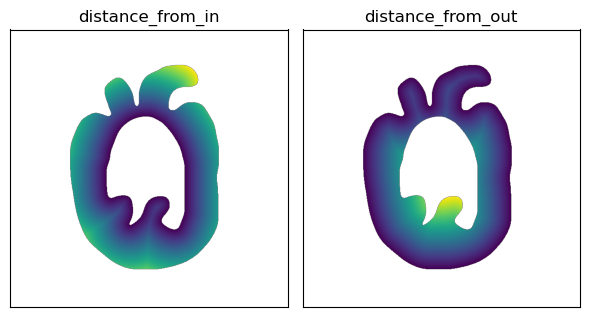

In [76]:
fig, axs = plt.subplots(1, 2, figsize = (6,4))

axs[0].set_title('distance_from_in')
axs[0].imshow(distance_from_in)

axs[1].set_title('distance_from_out')
axs[1].imshow(distance_from_out)


for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()

In [77]:
gy_in, gx_in = np.gradient(distance_from_in)

gy_out, gx_out = np.gradient(distance_from_out)

## functions

### find_closest function

In [78]:
def find_closest(p, edge, res=(1,1)):
    blank = np.zeros_like(edge)
    blank[p] = 1

    d = distance_transform_edt(~blank, sampling=res)
    d = np.ma.masked_array(d, ~edge)

    output_coords = tuple(int(c) for c in np.unravel_index(np.argmin(d), edge.shape))
    dist = float(d[output_coords])

    return output_coords, dist

### follow_gradient function

In [79]:
def follow_gradient_quantification(distance, start, edge_in, edge_out, res = (1,1), max_steps=1000, show = False):
    """
    Follow the distance gradient from start until reaching mask_in.
    start: tuple (row, col)
    mask_in: boolean array of internal edge
    """

    flag_in = edge_in[start[0], start[1]]
    flag_out = edge_out[start[0], start[1]]

    if flag_in:
        distance = -distance
        target_edge = edge_out
    elif flag_out:
        target_edge = edge_in
    else:
        target_edge = edge_in
    

    max_dist = 2 * np.max(distance)
    dist_data = np.ma.filled(distance, max_dist)

    gy, gx = np.gradient(dist_data)
    

    # it could have non valid gradient due to the mask
    pos = start.astype(float)

    length = 0
    pos_list = []

    if show:
        plt.imshow(distance)
        plt.xlim(start[1]-200,start[1]+200)
        plt.ylim(start[0]-200,start[0]+200)
    
    prev_move = np.zeros(2)
    alpha = 0.6

    for _ in range(max_steps):
        r, c = int(round(pos[0])), int(round(pos[1]))
        pos_list.append((r,c))
        if show:
            plt.scatter(c, r, s=0.1, c="#ff00c8")
        # condition to return if we reach the opposite edge
        if target_edge[r,c] == 1:
            if show:
                plt.show()
            
            return length, (r, c), pos_list
        
        # gradient at current position
        dr, dc = gy[tuple([r,c])], gx[tuple([r,c])]

        
        # Move in direction of steepest descent
        norm = np.hypot(dr * res[0], dc * res[1])
        if norm == 0:
            # I DONT KNOW WHAT IS THE PROBLEM, WHY IS IT STOPPING

            # print((r,c))
            # sometimes it might get stuck in points that don't belong to the edge
            proper_coord, dist_from_target = find_closest((r, c), target_edge, res=res)

            # for some readon adding this distance causes a lot of problems
            # length += dist_from_target

            if show:
                plt.show()
            return length, proper_coord, pos_list
        
        movement = np.array([dr, dc]) / (norm + 1e-8)
        movement = alpha * prev_move + (1 - alpha) * movement
        pos -= movement
        prev_move = movement

        length += np.hypot(res[0], res[1])


    proper_coord, dist_from_target = find_closest((r, c), target_edge, res=res)
    if show:
        plt.show()
    return length, (r, c), pos_list

## distance from IN

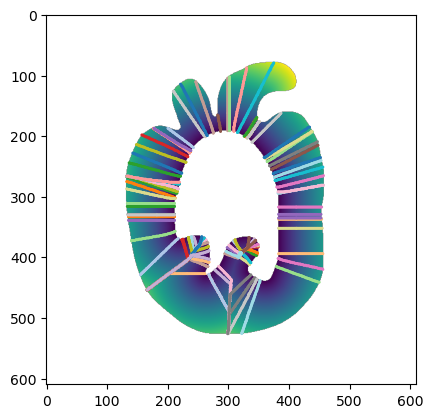

In [80]:
N = 100

coords = np.argwhere(edge_in)

idx = np.random.choice(len(coords), size=N)
points = coords[idx]

pos_list = []
col_list = []

for i, p in enumerate(points):
    _, _, current_pos_list = follow_gradient_quantification(distance_from_in, p, edge_in, edge_out)

    col_list += [i]*len(current_pos_list)
    pos_list = pos_list + current_pos_list

pos_list = np.array(pos_list)
x, y = pos_list[:,0], pos_list[:,1]

palette = sns.color_palette("tab20", N)  # also try "Set3", "Paired", "tab10"
colors = [palette[i % len(palette)] for i in col_list]

plt.imshow(distance_from_in)
plt.scatter(y, x, s=1, c = colors)

## distance from OUT

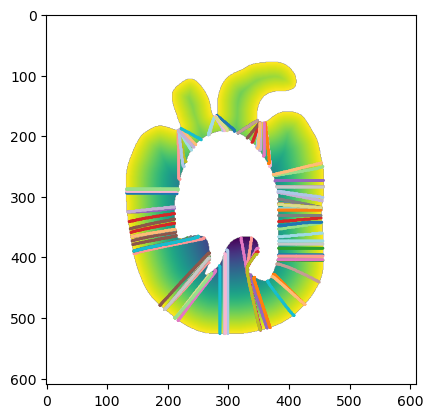

In [81]:
N = 100

coords = np.argwhere(edge_in)

idx = np.random.choice(len(coords), size=N)
points = coords[idx]

pos_list = []
col_list = []

for i, p in enumerate(points):
    _, _, current_pos_list = follow_gradient_quantification(-distance_from_out, p, edge_in, edge_out)

    col_list += [i]*len(current_pos_list)
    pos_list = pos_list + current_pos_list

pos_list = np.array(pos_list)
x, y = pos_list[:,0], pos_list[:,1]

palette = sns.color_palette("tab20", N)  # also try "Set3", "Paired", "tab10"
colors = [palette[i % len(palette)] for i in col_list]

plt.imshow(-distance_from_out)
plt.scatter(y, x, s=1, c = colors)

## magic distance

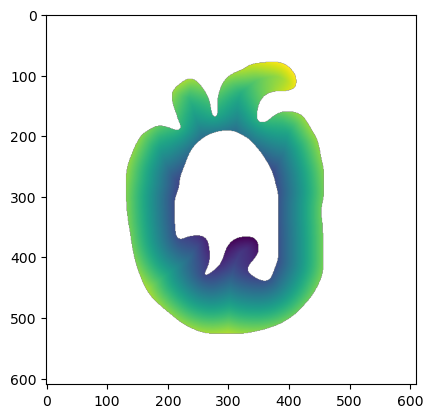

In [82]:
distance_from_out = distance_from_out / distance_from_out.max()
distance_from_in = distance_from_in / distance_from_in.max()

k = 10
dist_test =  distance_from_in*(1 / (k + distance_from_in)) - distance_from_out*(1 / (k + distance_from_out))

# dist_test = distance_from_in / distance_from_in.max()

plt.imshow(dist_test)

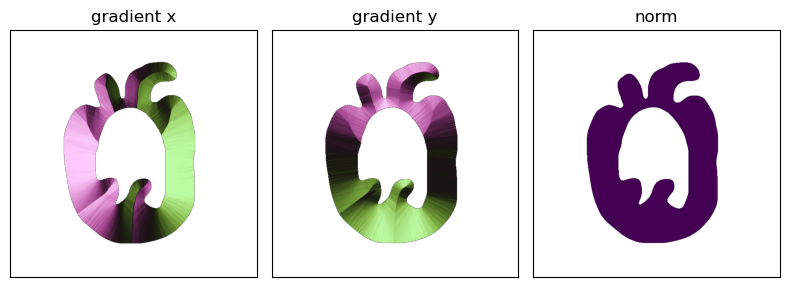

In [83]:
gy, gx = np.gradient(dist_test)

fig, axs = plt.subplots(1,3, figsize = (8,4))

axs[0].set_title('gradient x')
axs[0].imshow(gx, cmap='vanimo')

axs[1].set_title('gradient y')
axs[1].imshow(gy, cmap='vanimo')

axs[2].set_title('norm')

norm = gx**2 + gy**2

np.isclose(x, 0, atol=1e-6)
axs[2].imshow(np.isclose(norm, 0, atol=1))

for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()

In [84]:
# start = np.array([800, 300])

# l, _,_ = follow_gradient(dist_test, start, edge_in, edge_out, res=(1,1), max_steps=1000, show=True)
# print(l)

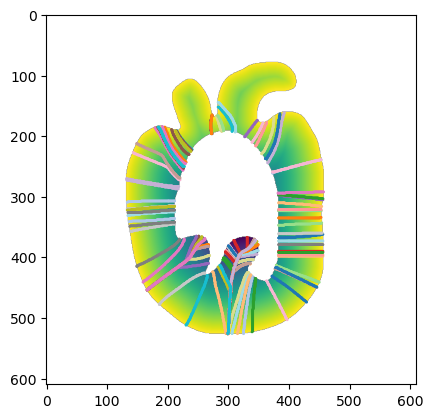

In [85]:
N = 100

coords = np.argwhere(edge_in)

idx = np.random.choice(len(coords), size=N)
points = coords[idx]

pos_list = []
col_list = []

for i, p in enumerate(points):
    _, _, current_pos_list = follow_gradient_quantification(dist_test, p, edge_in, edge_out)

    col_list += [i]*len(current_pos_list)
    pos_list = pos_list + current_pos_list

pos_list = np.array(pos_list)
x, y = pos_list[:,0], pos_list[:,1]

palette = sns.color_palette("tab20", N)  # also try "Set3", "Paired", "tab10"
colors = [palette[i % len(palette)] for i in col_list]

plt.imshow(-distance_from_out)
plt.scatter(y, x, s=1, c = colors)

In [86]:
in_df = pd.DataFrame()

coords_in_np = np.argwhere(edge_in)
coords_in = [tuple(map(int,c)) for c in coords_in_np]

in_df['p_in'] = coords_in


out_df = pd.DataFrame()

coords_out_np = np.argwhere(edge_out)
coords_out = [tuple(map(int,c)) for c in coords_out_np]

out_df['p_out'] = coords_out

In [87]:
in_df.head()

,p_in
0,"(191, 290)"
1,"(191, 291)"
2,"(191, 292)"
3,"(191, 293)"
4,"(191, 294)"


In [88]:
out_df.head()

,p_out
0,"(79, 362)"
1,"(79, 363)"
2,"(79, 364)"
3,"(79, 365)"
4,"(79, 366)"


In [89]:
reference_in_list = []

for i, p in enumerate(tqdm(coords_in)):
    p_np = np.array(p)
    l, target, _ = follow_gradient_quantification(dist_test, p_np, edge_in, edge_out)

    in_df.loc[i, 'dist'] = l
    reference_in_list.append(target)

in_df['p_out'] = reference_in_list



reference_out_list = []

for i, p in enumerate(tqdm(coords_out)):
    p_np = np.array(p)
    l, target, _ = follow_gradient_quantification(dist_test, p_np, edge_in, edge_out)

    out_df.loc[i, 'dist'] = l
    reference_out_list.append(target)

out_df['p_in'] = reference_out_list


100%|██████████| 1417/1417 [00:08<00:00, 159.21it/s]


In [90]:
# issues = [(101, 678),
# (98, 576),
# (130, 456),
# (138, 437),
# (316, 838),
# (374, 825),
# (403, 818),
# (424, 813),
# (500, 798),
# (837, 238),
# (1029, 423),
# (172, 612),
# (170, 632),
# (171, 666),
# (177, 699),
# (179, 705),
# (196, 509),
# (198, 503),
# (199, 500),
# (201, 494),
# (210, 473),
# (230, 437),
# (250, 407),
# (287, 779),
# (300, 777),
# (310, 775),
# (327, 771),
# (354, 764),
# (383, 756),
# (401, 751),
# (464, 264),
# (478, 275),
# (498, 297),
# (509, 310),
# (514, 317),
# (517, 321),
# (851, 705),
# (901, 685),
# (963, 613),
# (915, 676),
# (923, 670),
# (926, 667),
# (933, 661),
# (963, 631),
# (962, 632),
# (950, 645)]

# plt.imshow(dist_test)

# pos_list = np.array(issues)
# x, y = pos_list[:,0], pos_list[:,1]
# plt.scatter(y, x)

In [91]:
test = out_df.merge(in_df,
                    on = 'p_in',
                    how= 'outer')

In [92]:
test.head()

,p_out_x,dist_x,p_in,dist_y,p_out_y
0,"(168, 280)",38.183766,"(191, 290)",38.183766,"(167, 281)"
1,NaN,NaN,"(191, 291)",39.597980,"(166, 282)"
2,"(167, 281)",39.597980,"(191, 292)",41.012193,"(166, 282)"
3,NaN,NaN,"(191, 293)",43.840620,"(164, 282)"
4,NaN,NaN,"(191, 294)",48.083261,"(163, 283)"


In [93]:
test.shape

(1785, 5)

In [94]:
mask = test['p_out_x'].isna()

test.loc[mask, 'p_out_x'] = test.loc[mask, 'p_out_y'].values
test.loc[mask, 'dist_x'] = test.loc[mask, 'dist_y'].values

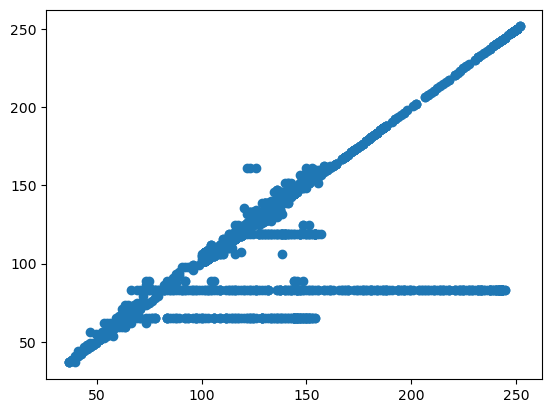

In [95]:
plt.scatter(test['dist_x'], test['dist_y'])

In [96]:
# dealing with 4 ref points
marks_df = pd.DataFrame()
labeled_mark, n_mark = label(ref_points)

print(labeled_mark.shape)

mark_coords = []
mark_sizes = []

for l in range(1, n_mark+1):
    current_mark = labeled_mark == l
    current_center = center_of_mass(current_mark)
    mark_coords.append(tuple(float(c) for c in current_center))

    mark_sizes.append(np.sum(current_mark))

marks_df['label'] = range(1, n_mark+1)
marks_df['coords'] = mark_coords
marks_df['size'] = mark_sizes

marks_df

(610, 610)


,label,coords,size
0,1,"(40.5, 280.5)",80
1,2,"(293.9642857142857, 551.7723214285714)",448
2,3,"(327.5, 41.5)",80
3,4,"(556.0, 259.5)",90


In [97]:
in_df['quadrant'] = 0

for i in range(n_mark):
    current_mark = marks_df['coords'][i]
    current_lab = marks_df['label'][i]

    point_dist = distance_transform_edt(labeled_mark != current_lab)
    # we fill with the max dist value
    base = np.ones_like(labeled_mark, dtype = float) * np.max(point_dist)
    # we put the actual dist values only on the edge_in
    base[edge_in.astype(bool)] = point_dist[edge_in.astype(bool)]
    # coord of the minimum
    current_in_coords = tuple(int(c) for c in np.unravel_index(np.argmin(base), base.shape))

    in_df.loc[in_df['p_in'] == current_in_coords, 'quadrant'] = 1
    # if the point is the biggest, it means it's the medial
    if marks_df['size'][i] == marks_df['size'].max():
        starting_in = current_in_coords

# order on ventricle perimeter
ordered_edge_in = ordered_edge_points(edge_in)
i = ordered_edge_in.index(starting_in)
ordered_edge_in = ordered_edge_in[i:] + ordered_edge_in[:i]
order_map = {p: i for i, p in enumerate(ordered_edge_in)}
in_df['order_in'] = in_df['p_in'].map(order_map)
in_df = in_df.sort_values(by='order_in', ignore_index=True)
in_df['quadrant'] = np.cumsum(in_df['quadrant'])
# in_df['order_in_norm'] = in_df['order_in']/in_df['order_in'].max()

in_df = in_df.sort_values(by='order_in')

In [98]:
in_df.head()

,p_in,dist,p_out,quadrant,order_in
0,"(297, 383)",106.066017,"(303, 456)",1,0
1,"(296, 382)",108.894444,"(292, 457)",1,1
2,"(295, 382)",108.894444,"(294, 457)",1,2
3,"(294, 382)",108.894444,"(292, 457)",1,3
4,"(293, 382)",108.894444,"(290, 457)",1,4


In [99]:
starting_point_out = in_df.loc[in_df['order_in'] == 0, 'p_out'].values[0]

ordered_edge_out = ordered_edge_points(edge_out)

i_out = ordered_edge_out.index(starting_point_out)
ordered_edge_out = ordered_edge_out[i_out:] + ordered_edge_out[:i_out]

order_map = {p: i for i, p in enumerate(ordered_edge_out)}
out_df['order_out'] = out_df['p_out'].map(order_map)

out_df = out_df.sort_values(by='order_out')

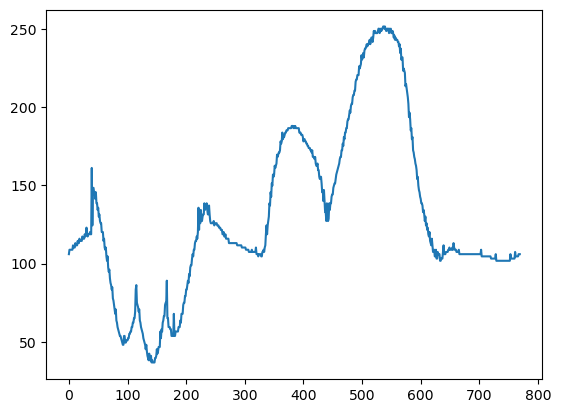

In [100]:
plt.plot(in_df['order_in'], in_df['dist'])

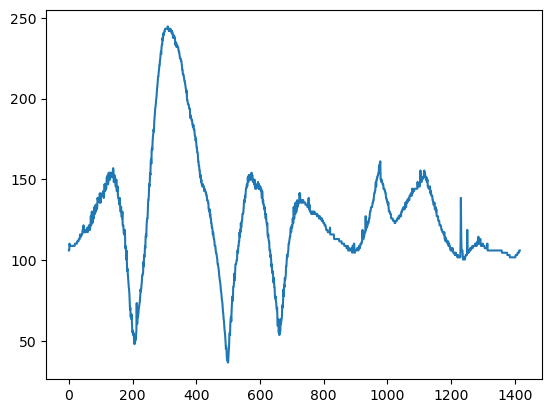

In [101]:
plt.plot(out_df['order_out'], out_df['dist'])

In [102]:
res_df = out_df.merge(in_df[['p_in', 'order_in', 'dist', 'quadrant']],
                      on='p_in',
                      how = 'outer')

res_df = res_df.sort_values(by = 'order_in').reset_index(drop=True)

res_df['dist_raw'] = 0.0

for k in res_df['order_in'].unique():

    current_block = res_df['order_in'] == k

    current_len = np.sum(current_block)

    if current_len == 1:
        res_df.loc[current_block, 'dist_raw'] = res_df.loc[current_block, 'dist_y']
    else:
        res_df.loc[current_block, 'dist_raw'] = (
            res_df.loc[current_block]
            .sort_values(by='order_out')['dist_x']
            .values
        )

res_df['final_order'] = range(len(res_df))
res_df['norm'] = res_df['final_order'] / res_df['final_order'].max()

w = int(len(res_df) / 40)
s = res_df['dist_raw']
s_ext = pd.concat([s.iloc[-w:], s, s.iloc[:w]])  # wrap around
s_smooth = s_ext.rolling(window=w, center=True).mean().iloc[w:-w].reset_index(drop=True)
res_df['dist'] = s_smooth

In [103]:
res_df.head()

,p_out,dist_x,p_in,order_out,order_in,dist_y,quadrant,dist_raw,final_order,norm,dist
0,"(303, 456)",106.066017,"(297, 383)",0.0,0,106.066017,1,106.066017,0,0.000000,106.291006
1,"(302, 456)",106.066017,"(297, 383)",1.0,0,106.066017,1,106.066017,1,0.000561,106.483853
2,"(306, 456)",106.066017,"(297, 383)",1414.0,0,106.066017,1,106.066017,2,0.001121,106.580277
3,"(305, 456)",106.066017,"(297, 383)",1415.0,0,106.066017,1,106.066017,3,0.001682,106.740983
4,"(304, 456)",106.066017,"(297, 383)",1416.0,0,106.066017,1,106.066017,4,0.002242,106.901689


In [104]:
output_df = res_df[['final_order', 'norm', 'dist']]

In [105]:
output_df.head()

,final_order,norm,dist
0,0,0.000000,106.291006
1,1,0.000561,106.483853
2,2,0.001121,106.580277
3,3,0.001682,106.740983
4,4,0.002242,106.901689


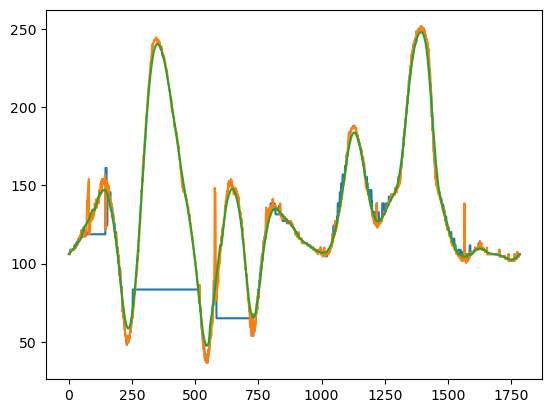

In [106]:
plt.plot(range(len(res_df)), res_df['dist_y'])
plt.plot(range(len(res_df)), res_df['dist_raw'])
plt.plot(range(len(res_df)), res_df['dist'])

In [107]:
res_df.head()

,p_out,dist_x,p_in,order_out,order_in,dist_y,quadrant,dist_raw,final_order,norm,dist
0,"(303, 456)",106.066017,"(297, 383)",0.0,0,106.066017,1,106.066017,0,0.000000,106.291006
1,"(302, 456)",106.066017,"(297, 383)",1.0,0,106.066017,1,106.066017,1,0.000561,106.483853
2,"(306, 456)",106.066017,"(297, 383)",1414.0,0,106.066017,1,106.066017,2,0.001121,106.580277
3,"(305, 456)",106.066017,"(297, 383)",1415.0,0,106.066017,1,106.066017,3,0.001682,106.740983
4,"(304, 456)",106.066017,"(297, 383)",1416.0,0,106.066017,1,106.066017,4,0.002242,106.901689
